# Прекод

# Сборный проект-5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [47]:
!pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.6 MB 495.5 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.6 MB 1.0 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.6 MB 1.8 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.6 MB 2.1 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.6 MB 3.2 MB/s eta 0:00:01
   ------------------------- -------------- 1.0/1.6 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.6 MB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 4.3 MB/s eta 0:00:00


In [179]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [5]:
def primary_information(df):
    display(df.info())
    display(df.head())

In [6]:
train_df = pd.read_csv("sp5/train_dataset.csv")
primary_information(train_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [7]:
crowd_df = pd.read_csv("sp5/CrowdAnnotations.tsv", sep="\t", names=[
    "filename", "description_id", "confirmed_percentage", "confirmed_qty", "disconfirmed_qty"
])
primary_information(crowd_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   filename              47830 non-null  object 
 1   description_id        47830 non-null  object 
 2   confirmed_percentage  47830 non-null  float64
 3   confirmed_qty         47830 non-null  int64  
 4   disconfirmed_qty      47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

,filename,description_id,confirmed_percentage,confirmed_qty,disconfirmed_qty
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [8]:
crowd_df['confirmed_percentage'].value_counts()

confirmed_percentage
0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1323
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: count, dtype: int64

Файл с краудсорсинговыми оценками содержит 47830 строк, пропущенных значений нет

In [10]:
expert_df = pd.read_csv("sp5/ExpertAnnotations.tsv", sep="\t", names=[
    "filename", "description_id", "exp1", "exp2", "exp3"
])
primary_information(expert_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   filename        5822 non-null   object
 1   description_id  5822 non-null   object
 2   exp1            5822 non-null   int64 
 3   exp2            5822 non-null   int64 
 4   exp3            5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

,filename,description_id,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Датасет содержит 5822 строки, пропущенных значений нет

In [12]:
annotations_df = pd.merge(
    left=crowd_df, 
    right=expert_df,
    how='inner',
    left_on=['filename', 'description_id'],
    right_on=['filename', 'description_id'],
)
primary_information(annotations_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   filename              2329 non-null   object 
 1   description_id        2329 non-null   object 
 2   confirmed_percentage  2329 non-null   float64
 3   confirmed_qty         2329 non-null   int64  
 4   disconfirmed_qty      2329 non-null   int64  
 5   exp1                  2329 non-null   int64  
 6   exp2                  2329 non-null   int64  
 7   exp3                  2329 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 145.7+ KB


None

,filename,description_id,confirmed_percentage,confirmed_qty,disconfirmed_qty,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0,3,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000,0,3,1,1,2
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.000000,0,3,1,1,2
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,0.000000,0,3,1,2,3
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,0.333333,1,2,2,3,3


In [13]:
annotations_df[annotations_df['confirmed_percentage'].isna()|annotations_df['exp1'].isna()]

,filename,description_id,confirmed_percentage,confirmed_qty,disconfirmed_qty,exp1,exp2,exp3


In [14]:
annotations_df

,filename,description_id,confirmed_percentage,confirmed_qty,disconfirmed_qty,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0,3,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000,0,3,1,1,2
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.000000,0,3,1,1,2
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,0.000000,0,3,1,2,3
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,0.333333,1,2,2,3,3
...,...,...,...,...,...,...,...,...
2324,979383193_0a542a059d.jpg,3244747165_17028936e0.jpg#2,0.000000,0,3,2,2,2
2325,979383193_0a542a059d.jpg,3482062809_3b694322c4.jpg#2,0.000000,0,3,1,2,2
2326,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000,0,3,1,1,1
2327,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.000000,0,3,1,1,2


In [15]:
def target_calc(x):
    return x['confirmed_percentage'] * 0.4 + ((x['exp1'] + x['exp2'] + x['exp3']) / 3. - 1) / 3. * 0.6

<Axes: >

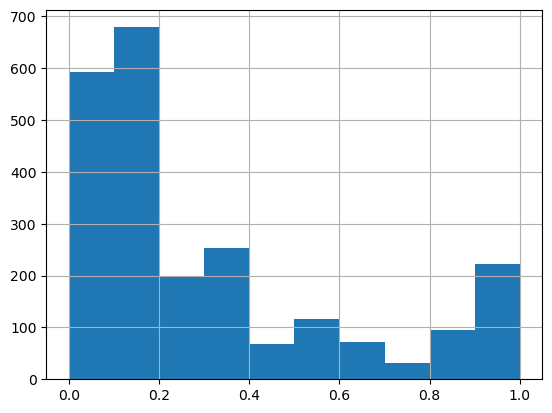

In [16]:
annotations_df['target'] = annotations_df.apply(target_calc, axis=1)
annotations_df['target'].hist()

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [18]:
stopwords = ['child', 'boy', 'girl', 'kid', 'kids', 'children']

In [19]:
idx = train_df[train_df['query_text'].str.extract(f"({'|'.join(stopwords)})").notna()[0]].index
train_df = train_df.drop(idx).reset_index(drop=True)
train_df

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
...,...,...,...
4386,799486353_f665d7b0f0.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ..."
4387,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
4388,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
4389,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [141]:
TRAIN_IMG_PATH = 'sp5/train_images'

In [117]:
resnet = models.resnet50(pretrained=True) #загружаем претренированную модель

for param in resnet.parameters():
    param.requires_grad_(False)

C:\Users\Zhenya-PC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Zhenya-PC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules) 

In [121]:
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [123]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [137]:
img = Image.open("sp5/train_images/488590040_35a3e96c89.jpg").convert('RGB')
input_tensor = preprocess(img)
output_tensor = resnet(input_tensor.unsqueeze(0)).flatten() # сразу спрямим тензор в вектор

In [143]:
def create_embeddings(x):
    img = Image.open(f"{TRAIN_IMG_PATH}/{x}").convert('RGB')
    return resnet(preprocess(img).unsqueeze(0)).flatten()

In [147]:
train_df['image_embeddings'] = train_df['image'].apply(create_embeddings)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска